# Logistic Regression

### 1st December 2015 Neil D. Lawrence

In [1]:
import numpy as np
import pandas as pd
import pods
import matplotlib.pyplot as plt
%matplotlib inline


The [naive Bayes assumption](./week9.ipynb) allowed us to specify a class conditional density, $p(\mathbf{x}_i|y_i, \boldsymbol{\theta})$, through assuming that the features were conditionally independent given the label. Combined with our assumption that the data points are conditionally independent given the parameters, $\boldsymbol{\theta}$, this allowed us to specify a joint density over the entire data set, $p(\mathbf{y}, \mathbf{X})$. We argued that modeling the joint density is a powerful approach because we can answer any particular question we have about the data through the sum rule and the product rule of probability. We can condition on the training data and query the value of an unseen test point. If we have missing data, then we can integrate over the missing point (marginalise) and obtain our best prediction despite the absence of some of the features for a point. However, it comes at the cost of a particular modeling assumption. Namely, to make modeling practical we assumed that the features were conditionally independent given the feature label. In other words, for any given point, if we know its class, then its features will be independent. This is a very strong assumption. For example, if we were classifying the sex of an individual given their height and weight, naive Bayes would assume that if we knew their sex, then the height and weight would be independent. This is clearly wrong, the dependence between height and weight is not dictated only by the sex of an individual, there is a natural correlation between them.

Modeling the entire joint density allows us to deal with different questions, that we may not have envisaged at the model *design time*. It contrasts with the approach we took for regression where we specifically chose to model the conditional density for the target values, $\mathbf{y}$, given the input locations, $\mathbf{X}$. That density, $p(\mathbf{y}|\mathbf{X})$, effectively assumes that the question we'll be asked at *run time* is known. In particular, we expect to be asked about the value of the function, $y^*$, given a particular input location, $\mathbf{x}^*$. We don't expect to be asked about the value of an input given a particular observation. That would require placing an additional prior over the input location for each point, $p(\mathbf{x}_i)$. Of course, it's possible to conceive of a model like this, and indeed that is how we proceeded for [dimensionality reduction](./week8.ipynb). However, if we know we will always have all the inputs at run time, it may make sense to *directly* model the conditional density, $p(\mathbf{y}|\mathbf{X})$. 

## Logistic Regression

A logistic regression is an approach to classification which extends the linear basis function models we've already explored. Rather than modeling the output of the function directly the assumption is that we model the *log-odds* with the basis functions.

The [odds](http://en.wikipedia.org/wiki/Odds) are defined as the ratio of the probability of a positive outcome, to the probability of a negative outcome. If the probability of a positive outcome is denoted by $\pi$, then the odds are computed as $\frac{\pi}{1-\pi}$. Odds are widely used by [bookmakers](http://en.wikipedia.org/wiki/Bookmaker) in gambling, although a bookmakers odds won't normalise: i.e. if you look at the equivalent probabilities, and sum over the probability of all outcomes the bookmakers are considering, then you won't get one. This is how the bookmaker makes a profit. 

Because a probability is always between zero and one, the odds are always between $0$ and $\infty$. If the positive outcome is unlikely the odds are close to zero, if it is very likely then the odds become close to infinite. Taking the logarithm of the odds maps the odds from the positive half space to being across the entire real line. Odds that were between 0 and 1 (where the negative outcome was more likely) are mapped to the range between $-\infty$ and $0$. Odds that are greater than 1 are mapped to the range between $0$ and $\infty$. Considering the log odds therefore takes a number between 0 and 1 (the probability of positive outcome) and maps it to the entire real line. The function that does this is known as the [logit function](http://en.wikipedia.org/wiki/Logit),
$
g^{-1}(p_i) = \log\frac{p_i}{1-p_i}
$
This function is known as a *link function*.

For a standard regression we take,
$$
f(x) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}),
$$
if we want to perform classification we perform a logistic regression. 
$$
\log \frac{\pi}{(1-\pi)} = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
where the odds ratio between the positive class and the negative class is given by
$$
\frac{\pi}{(1-\pi)}
$$
The odds can never be negative, but can take any value from 0 to $\infty$. We have defined the link function as taking the form $g^{-1}(\cdot)$ implying that the inverse link function is given by $g(\cdot)$. Since we have defined,
$$
g^{-1}(\pi) = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})
$$
we can write $\pi$ in terms of the *inverse link* function, $g(\cdot)$ as 
$$
\pi = g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})).
$$

### Basis Function

We'll define our prediction, objective and gradient functions below. But before we start, we need to define a basis function for our model. Let's start with the linear basis.

In [2]:
def linear(x, **kwargs):
    "Defines the linear basis."
    return np.hstack([np.ones((X.shape[0], 1)), X])

### Prediction Function

Now we have the basis function let's define the prediction function.

In [3]:
def predict(w, x, basis=linear, **kwargs):
    "Generates the prediction function and the basis matrix."
    Phi = basis(x, **kwargs)
    f = np.dot(Phi, w)
    return 1./(1+np.exp(-f)), Phi

This inverse of the link function is known as the [logistic](http://en.wikipedia.org/wiki/Logistic_function) (thus the name logistic regression) or sometimes it is called the sigmoid function. For a particular value of the input to the link function, $f_i = \mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)$ we can plot the value of the link function as below.

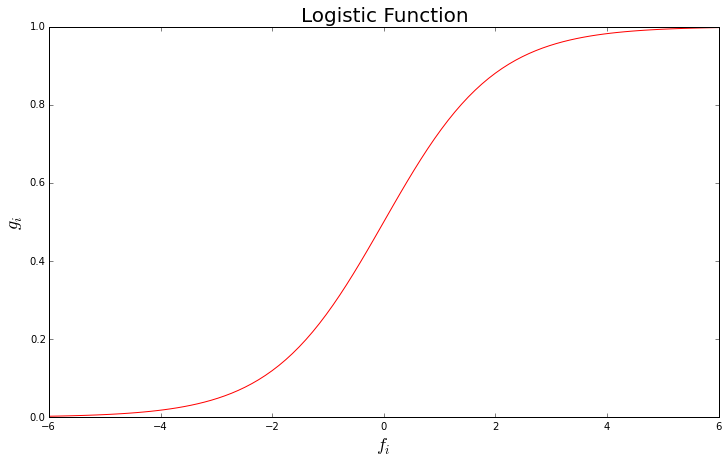

In [4]:
fig, ax = plt.subplots(figsize=(12, 7))
f = np.linspace(-6, 6, 100)
g = 1/(1+np.exp(-f))
ax.plot(f, g, 'r-')
ax.set_title('Logistic Function', fontsize=20)
ax.set_xlabel('$f_i$', fontsize=18)
ax.set_ylabel('$g_i$', fontsize=18)

The function has this characeristic 's'-shape (from where the term sigmoid, as in sigma, comes from). It also takes the input from the entire real line and 'squashes' it into an output that is between zero and one. For this reason it is sometimes also called a 'squashing function'. 

By replacing the inverse link with the sigmoid we can write $\pi$ as a function of the input and the parameter vector as, 
$$
\pi(\mathbf{x},\mathbf{w}) = \frac{1}{1+ \exp\left(-\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}.
$$

The process for logistic regression is as follows. Compute the output of a standard linear basis function composition ($\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})$, as we did for linear regression) and then apply the inverse link function, $g(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}))$. In logistic regression this involves *squashing* it with the logistic (or sigmoid) function. Use this value, which now has an interpretation as a *probability* in a Bernoulli distribution to form the likelihood. Then we can assume conditional independence of each data point given the parameters and develop a likelihod for the entire data set. 

As we discussed last time, the Bernoulli likelihood is of the form,
$$
P(y_i|\mathbf{w}, \mathbf{x}) = \pi_i^{y_i} (1-\pi_i)^{1-y_i}
$$
which we can think of as clever trick for mathematically switching between two probabilities if we were to write it as code it would be better described as
```python
def bernoulli(x, y, pi):
    if y == 1:
        return pi(x)
    else:
        return 1-pi(x)
```
but writing it mathematically makes it easier to write our objective function within a single mathematical equation. 

## Maximum Likelihood

To obtain the parameters of the model, we need to maximize the likelihood, or minimize the objective function, normally taken to be the negative log likelihood. With a data conditional independence assumption the likelihood has the form,
$$
P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \prod_{i=1}^n P(y_i|\mathbf{w}, \mathbf{x}_i). 
$$
which can be written as a log likelihood in the form
$$
\log P(\mathbf{y}|\mathbf{w}, \mathbf{X}) = \sum_{i=1}^n \log P(y_i|\mathbf{w}, \mathbf{x}_i) = \sum_{i=1}^n y_i \log \pi_i + \sum_{i=1}^n (1-y_i)\log (1-\pi_i)
$$
and if we take the probability of positive outcome for the $i$th data point to be given by
$$
\pi_i = g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right),
$$
where $g(\cdot)$ is the *inverse* link function, then this leads to an objective function of the form,
$$
E(\mathbf{w}) = -  \sum_{i=1}^n y_i \log g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right) - \sum_{i=1}^n(1-y_i)\log \left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x}_i)\right)\right).
$$

In [79]:
def objective(g, y):
    "Computes the objective function."
    posind = np.where(y.flatten()==1)
    negind = np.where(y.flatten()==0)
    return -np.log(g[posind, :]).sum() - np.log(1-g[negind, :]).sum()


As normal, we would like to minimize this objective. This can be done by differentiating with respect to the parameters of our prediction function, $\pi(\mathbf{x};\mathbf{w})$, for optimisation. The gradient of the likelihood with respect to $\pi(\mathbf{x};\mathbf{w})$ is of the form,
$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n \frac{y_i}{g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n \frac{1-y_i}{1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)}\frac{\text{d}g(f_i)}{\text{d}f_i} \boldsymbol{\phi(\mathbf{x}_i)}
$$
where we used the chain rule to develop the derivative in terms of $\frac{\text{d}g(f_i)}{\text{d}f_i}$, which is the gradient of the inverse link function (in our case the gradient of the sigmoid function).

So the objective function now depends on the gradient of the inverse link function, as well as the likelihood depends on the gradient of the inverse link function, as well as the gradient of the log likelihood, and naturally the gradient of the argument of the inverse link function with respect to the parameters, which is simply $\boldsymbol{\phi}(\mathbf{x}_i)$.

The only missing term is the gradient of the inverse link function. For the sigmoid squashing function we have,
\begin{align*}
g(f_i) &= \frac{1}{1+\exp(-f_i)}\\
&=(1+\exp(-f_i))^{-1}
\end{align*}
and the gradient can be computed as
\begin{align*}
\frac{\text{d}g(f_i)}{\text{d} f_i} & = \exp(-f_i)(1+\exp(-f_i))^{-2}\\
& = \frac{1}{1+\exp(-f_i)} \frac{\exp(-f_i)}{1+\exp(-f_i)} \\
& = g(f_i) (1-g(f_i))
\end{align*}
so the full gradient can be written down as
$$
\frac{\text{d}E(\mathbf{w})}{\text{d}\mathbf{w}} = -\sum_{i=1}^n y_i\left(1-g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)} +  \sum_{i=1}^n (1-y_i)\left(g\left(\mathbf{w}^\top \boldsymbol{\phi}(\mathbf{x})\right)\right) \boldsymbol{\phi(\mathbf{x}_i)}.
$$

In [80]:
def gradient(g, Phi, y):
    "Generates the gradient of the parameter vector."
    posind = np.where(y.flatten()==1)
    dw = -(Phi[posind]*(1-g[posind])).sum(0)
    negind = np.where(y.flatten()==0 )
    dw += (Phi[negind]*g[negind]).sum(0)
    return dw[:, None]

## Optimization of the Function

Reorganizing the gradient to find a stationary point of the function with respect to the parameters $\mathbf{w}$ turns out to be impossible. Optimization has to proceed by *numerical methods*. Options include the multidimensional variant of [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method) or [gradient based optimization methods](http://en.wikipedia.org/wiki/Gradient_method) like we used for optimizing matrix factorization for the movie recommender system. We recall from matrix factorization that, for large data, *stochastic gradient descent* or the Robbins Munroe optimization procedure worked best for function minimization. 

## Movie Body Count Data

Let's recreate the movie body count example we used with naive Bayes. We can load in the data from `pods` as follows.

In [81]:
% Change this example for 2016#data = pods.datasets.movie_body_count_r_classify()
data = pods.datasets.olivetti_glasses()
X = data['X']
y = data['Y']

ERROR: Line magic function `%Change` not found.


## Gradient Descent

We will need to define some initial random values for our vector and then minimize the objective by descending the gradient.

In [89]:
# gradient descent algorithm
w = np.random.normal(size=(X.shape[1]+1, 1), scale = 0.001)
eta = 1e-9
iters = 10000
for i in range(iters):
    g, Phi = predict(w, X, linear)
    w -= eta*gradient(g, Phi, y) + 0.001*w
    if not i % 100:
        print("Iter", i, "Objective", objective(g, y))

Iter 0 Objective 631.783196247
Iter 100 Objective 129.578605944
Iter 200 Objective 91.2451010919
Iter 300 Objective 65.2537459773
Iter 400 Objective 48.0332121367
Iter 500 Objective 42.4937469629
Iter 600 Objective 39.5273578953
Iter 700 Objective 37.4964014119
Iter 800 Objective 36.064994686
Iter 900 Objective 35.0348514251
Iter 1000 Objective 34.2819537383
Iter 1100 Objective 33.7251857125
Iter 1200 Objective 33.3096324019
Iter 1300 Objective 32.9971217868
Iter 1400 Objective 32.7605772912
Iter 1500 Objective 32.5804914621
Iter 1600 Objective 32.4426402661
Iter 1700 Objective 32.3365549167
Iter 1800 Objective 32.2544738537
Iter 1900 Objective 32.1906090092
Iter 2000 Objective 32.1406235049
Iter 2100 Objective 32.1012549001
Iter 2200 Objective 32.0700405632
Iter 2300 Objective 32.045115822
Iter 2400 Objective 32.0250646355
Iter 2500 Objective 32.0088085498
Iter 2600 Objective 31.9955237856
Iter 2700 Objective 31.9845791263
Iter 2800 Objective 31.9754892638
Iter 2900 Objective 31.96787

In [63]:
%debug

> <ipython-input-58-f605ddfceb15>(4)gradient()
      3     posind = np.where(y.flatten()==1)
----> 4     dw = -(Phi[posind, :]*(1-g[np.where(posind), :])).sum(0)
      5     negind = np.where(y.flatten()==0 or y.flatten()==-1)

ipdb> Phi[posind, :].shape
(1, 63, 4097)
ipdb> posind.shape
*** AttributeError: 'tuple' object has no attribute 'shape'
ipdb> posind
(array([  0,   9,  18,  20,  23,  29,  34,  38,  43,  44,  55,  56,  58,
        59,  62,  64,  69,  71,  72,  76,  81,  83,  84,  99, 101, 102,
       107, 108, 112, 116, 118, 119, 121, 123, 124, 126, 127, 128, 130,
       140, 142, 147, 149, 151, 152, 153, 154, 156, 164, 170, 174, 178,
       179, 182, 183, 184, 185, 186, 187, 190, 195, 197, 198]),)
ipdb> Phi.shape
(200, 4097)
ipdb> Phi[posind].shape
(63, 4097)
ipdb> q


In [50]:
len(g[np.where(y.flatten()==1)])

63

In [49]:
np.where(y.flatten()==1)

(array([  0,   9,  18,  20,  23,  29,  34,  38,  43,  44,  55,  56,  58,
         59,  62,  64,  69,  71,  72,  76,  81,  83,  84,  99, 101, 102,
        107, 108, 112, 116, 118, 119, 121, 123, 124, 126, 127, 128, 130,
        140, 142, 147, 149, 151, 152, 153, 154, 156, 164, 170, 174, 178,
        179, 182, 183, 184, 185, 186, 187, 190, 195, 197, 198]),)

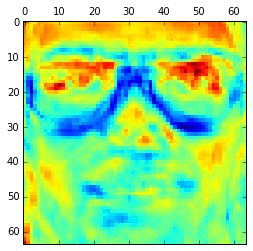

In [90]:
plt.matshow(w[1:].reshape(64, 64).T)

Let's look at the weights and how they relate to the inputs. 

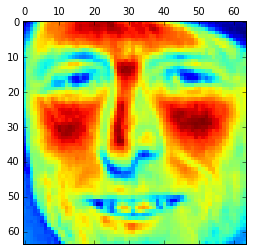

In [36]:
plt.matshow(X[40, :].reshape(64, 64).T)

In [91]:
(linear(X)*w.T).sum(1)

array([ 1.39022521, -4.33047537, -2.61829807, -2.38789405, -2.2484106 ,
       -1.26540661, -5.59135337, -3.02146683, -2.33078945,  3.14770712,
       -0.49667949, -1.5964594 , -1.12955127, -3.36960833, -3.06438023,
       -4.95170888, -2.96473025, -4.56202041,  1.0628996 , -2.47568987,
        2.09219783, -1.66695307, -4.60386364,  1.90781083, -4.10077389,
       -2.6102965 , -3.66659041, -1.58807206, -1.43886635,  1.49579457,
       -3.59460098, -1.72435831, -1.84683046, -2.30974171,  1.68886277,
       -2.24711233, -1.95581952, -2.31658807,  1.39246453, -3.52236602,
       -2.46438108, -1.74420947, -2.68376611,  1.71993236,  2.28411349,
       -3.84814696, -1.50678481, -1.30813672, -1.77439492, -2.47435533,
       -1.5510016 , -2.22658835, -2.61229978, -3.12341   , -4.61323338,
        0.50842128,  1.17957683, -3.18913943,  0.97965631,  1.63319012,
       -1.23967675, -1.95116466,  1.21742364, -3.99316546,  0.62752442,
       -1.34482841, -1.13117605, -1.23336778, -2.98187276,  0.55

The weights are fairly small. This makes sense for year, and perhaps also body count, but given the genre only take the value of 0 or 1 it makes less sense for them. Why are the weights so small? What can you do to fix this?

## Stochastic Gradient Descent

Now construct a stochastic gradient descent algorithm and run it on the data. Is it faster or slower than batch gradient descent? What can you do to improve convergence speed?

## Going Further

### Optimization

Other optimization techniques for generalized linear models include [Newton's method](http://en.wikipedia.org/wiki/Newton%27s_method), it requires you to compute the Hessian, or second derivative of the objective function. 

Methods that are based on gradients only include [L-BFGS](http://en.wikipedia.org/wiki/Limited-memory_BFGS) and [conjugate gradients](http://en.wikipedia.org/wiki/Conjugate_gradient_method). Can you find these in python? Are they suitable for very large data sets? 

### Other GLMs

We've introduced the formalism for generalized linear models. Have a think about how you might model count data using the [Poisson distribution](http://en.wikipedia.org/wiki/Poisson_distribution) and a log link function for the rate, $\lambda(\mathbf{x})$. If you want a data set you can try the `pods.datasets.google_trends()` for some count data.

### Bayesian Approaches

Can you place a prior density over the parameters $\mathbf{w}$ and marginalize them out like we did for linear regression? If not why not?



In [ ]:
p